# testing basic copy of code


In [ ]:

from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils


In [ ]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['Walking',
'Jogging',
'Stairs',
'Sitting',
'Standing',
'Typing',
'Brushing Teeth',
'Eating Soup',
'Eating Chips',
'Eating Pasta',
'Drinking from Cup',
'Eating Sandwich',
'Kicking (Soccer Ball)',
'Playing Catch w/Tennis Ball',
'Dribblinlg (Basketball)',
'Writing',
'Clapping',
'Folding Clothes']
# The number of steps within one time segment
TIME_PERIODS = 256
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 32

keras version  2.12.0


In [ ]:
def read_data(file_path):
    df = pd.read_csv(file_path,header=None)
    return df

def show_basic_dataframe_info(dataframe):
    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))


#df_mobile_acc = read_data('gdrive/My Drive/WISDM_12_classDataset/combinePhoneAcc.csv')
#df_mobile_acc.columns = ['PersonID','label','timeStamp','AccX','AccY','AccZ']
df = read_data('WatchAccGyroMagData.csv')
df.columns = ['label','timestamp','ax','ay','az','gx','gy','gz','AccMag','GyroMag']

In [ ]:
# Describe the data
show_basic_dataframe_info(df)
df=df.drop(df.index[0])
df.head()

Number of columns in the dataframe: 10
Number of rows in the dataframe: 1048575



,label,timestamp,ax,ay,az,gx,gy,gz,AccMag,GyroMag
1,A,90426807196641,3.3,-0.2,6.1,0.4,-0.6,-0.0,-2.9,-9.1
2,A,90426856696641,2.8,-0.2,6.0,0.1,-0.2,-0.2,-3.2,-9.5
3,A,90426906196641,3.8,-1.1,7.7,0.0,0.3,-0.2,-1.1,-9.5
4,A,90426955696641,4.7,0.2,9.7,0.1,0.7,-0.0,0.9,-9.1
5,A,90427005196641,6.1,0.8,11.0,-0.1,1.1,-0.1,2.8,-8.7


In [ ]:
df['AccMag']=df['AccMag'].astype('float')

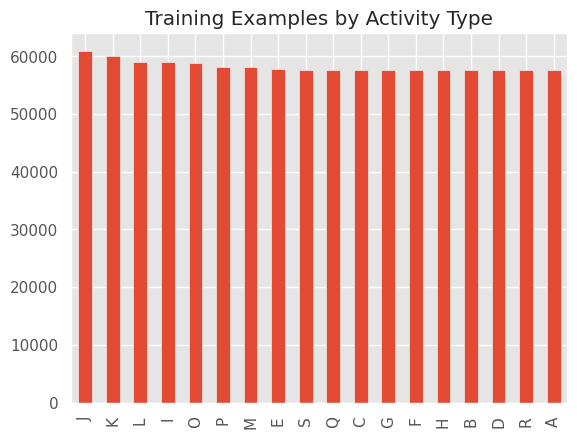

<Figure size 1800x1800 with 0 Axes>

In [ ]:
# Show how many training examples exist for each of the six activities
df['label'].value_counts().plot(kind='bar',title='Training Examples by Activity Type')
plt.figure(figsize=(18, 18))
plt.show()


In [ ]:
LABEL = 'ActivityEncoded'
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['label'].values.ravel())

In [ ]:
# Differentiate between test set and training set
def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 1 #2
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        ax = df['AccMag'].values[i: i + time_steps]
        #GyroMag=df['GyroMag'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([ax])#,GyroMag])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [ ]:
x_data, y_data = create_segments_and_labels(df,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                             LABEL )

#df_test = df[df['user-id'] > 28]
#df_train = df[df['user-id'] <= 28]
print (x_data.shape)
print(y_data.shape)

<ipython-input-71-022da8de1bd9>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df[label_name][i: i + time_steps])[0][0]


(32760, 256, 1)
(32760,)


In [ ]:
#deviding dataset into 70 % (train) and 30% test chuncks
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(22932, 256, 1) (22932,)
(9828, 256, 1) (9828,)


In [ ]:
#further saving 15 % from the total of 30 % test data into cross and test
X_cross, X_test, y_cross, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print(X_cross.shape, y_cross.shape)
print(X_test.shape, y_test.shape)

(4914, 256, 1) (4914,)
(4914, 256, 1) (4914,)


In [ ]:
print(type(x_data))

<class 'numpy.ndarray'>


In [ ]:
# Set input & output dimensions
num_time_periods, num_sensors = X_train.shape[1], X_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'O', 'P', 'Q', 'R', 'S']


In [ ]:
print('X_train shape: ', X_train.shape)
print(X_train.shape[0], 'training samples')
y_train = np_utils.to_categorical(y_train, num_classes)
print('y_train shape: ', y_train.shape)

X_train shape:  (22932, 256, 1)
22932 training samples
y_train shape:  (22932, 18)


In [ ]:
print('X_test shape: ', X_test.shape)
print(X_test.shape[0], 'testing samples')
y_test = np_utils.to_categorical(y_test, num_classes)
print('y_test shape: ', y_test.shape)

X_test shape:  (4914, 256, 1)
4914 testing samples
y_test shape:  (4914, 18)


In [ ]:
print('X_cross shape: ', X_cross.shape)
print(X_cross.shape[0], 'cross samples')
y_cross = np_utils.to_categorical(y_cross, num_classes)
print('y_cross shape: ', y_cross.shape)

X_cross shape:  (4914, 256, 1)
4914 cross samples
y_cross shape:  (4914, 18)


##my model


In [ ]:
from keras import models
from keras.models import Model
from keras.layers import Input
import tensorflow
from keras.layers import add
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# from keras.utils import to_categorical

In [ ]:
from keras.layers import GRU
from keras.layers import LSTM, Bidirectional, BatchNormalization

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Dropout, concatenate, Flatten, Dense, Bidirectional, GRU, Multiply
from tensorflow.keras.models import Model

In [ ]:
def attention_module(input_layer, hidden_units):
    attention = Dense(hidden_units, activation='tanh')(input_layer)
    attention = Dense(1, activation='softmax')(attention)
    attention = Multiply()([input_layer, attention])
    return attention

def create_model(trainX, trainy):
  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  input_shape=(n_timesteps,n_features)
  #first two signals
  signal_input = Input(shape=input_shape, name='data')
  gru1=Bidirectional(GRU(64,return_sequences=True))(signal_input)
  bn=BatchNormalization()(gru1)
  bn = attention_module(bn, hidden_units=256)

  layer_1_a = Conv1D(filters=64,  kernel_size=1, padding='same', activation='relu',name='1x1_a_3')(bn) #with 1x1 conv
  layer_1_a = Conv1D(filters=64,  kernel_size=3, padding='same', activation='relu',name='1x3_a')(layer_1_a) # with 1x3

  layer_2_a = Conv1D(64,  kernel_size=1, padding='same', activation='relu',name='1x1_a_5')(bn) #with 1x1
  layer_2_a = Conv1D(64,  kernel_size=5, padding='same', activation='relu',name='1x5_a')(layer_2_a)#with 1x5

  layer_3_a = Conv1D(64,  kernel_size=1, padding='same', activation='relu',name='1x1_a_7')(bn) #with 1x1
  layer_3_a = Conv1D(64,  kernel_size=7, padding='same', activation='relu',name='1x7_a')(layer_3_a) #with 1x7

  layer_1_direct = Conv1D(filters=64,  kernel_size=1, padding='same', activation='relu',name='1x1_a_direct')(bn) #with 1x1 conv

  layer_4_b = MaxPooling1D(pool_size=1, padding='same',name='MaxPool_b_1')(bn) # pooling
  layer_4_b = Conv1D(64,  kernel_size=1, padding='same', activation='relu',name='MaxPool_1x1_b')(layer_4_b) # with 1x1

  mid_1_a = keras.layers.concatenate([layer_1_a, layer_2_a,layer_3_a,layer_1_direct,layer_4_b], axis = 2)
  drop2=Dropout(0.5)(mid_1_a)
  #<------------------------------------------------------------Concatenated Module 1 with input---------------------->
  mid_1_a=Conv1D(filters=128,  kernel_size=1, padding='same', activation='relu',name='a_1x1_size_reduce')(drop2)

  #<-----Ending network ----->
  before_flat=Conv1D(filters=64,  kernel_size=1, padding='same', activation='relu',name='before_2_1x1_size_reduce')(mid_1_a)

  globelAverage=keras.layers.GlobalAveragePooling1D(data_format='channels_last')(before_flat)

  out = Dense(n_outputs, activation='softmax', name='predictions')(globelAverage)

  rez = Model(inputs=signal_input, outputs=out)

  return rez

In [ ]:
model=create_model(X_train, y_train)

In [ ]:
print (model)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 1)]     0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 256, 128)    25728       ['data[0][0]']                   
 )                                                                                                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 256, 128)    512         ['bidirectional_2[0][0]']        
 rmalization)                                                                                     
                                                                                            

In [ ]:
model.save('Attension(afterBiGRU)-UltaNet.h5')

In [ ]:
inception= model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
import datetime
begin_time = datetime.datetime.now()
verbose, epochs, batch_size = 0, 100, 120 # here are the parameters of training verbose, epoch, batchSize
history=model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)#, verbose=1,callbacks=[es])
print(datetime.datetime.now() - begin_time)
# evaluate model

Epoch 1/100
192/192 [==============================] - 20s 56ms/step - loss: 1.5664 - accuracy: 0.4471 - val_loss: 1.4051 - val_accuracy: 0.5305
Epoch 2/100
192/192 [==============================] - 10s 54ms/step - loss: 1.0449 - accuracy: 0.6161 - val_loss: 1.0245 - val_accuracy: 0.6154
Epoch 3/100
192/192 [==============================] - 10s 51ms/step - loss: 0.8996 - accuracy: 0.6730 - val_loss: 0.8421 - val_accuracy: 0.6874
Epoch 4/100
192/192 [==============================] - 10s 52ms/step - loss: 0.8367 - accuracy: 0.6964 - val_loss: 0.8240 - val_accuracy: 0.7007
Epoch 5/100
192/192 [==============================] - 10s 54ms/step - loss: 0.7765 - accuracy: 0.7175 - val_loss: 0.7716 - val_accuracy: 0.7139
Epoch 6/100
192/192 [==============================] - 11s 56ms/step - loss: 0.7365 - accuracy: 0.7347 - val_loss: 0.7411 - val_accuracy: 0.7186
Epoch 7/100
192/192 [==============================] - 10s 54ms/step - loss: 0.7047 - accuracy: 0.7418 - val_loss: 0.7197 - val_ac

In [ ]:
_, accuracy = model.evaluate(X_cross, y_cross, batch_size=batch_size, verbose=0)
print ("accuracy = ",accuracy*100)

accuracy =  96.6422438621521


In [ ]:
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print ("accuracy = ",accuracy*100)

accuracy =  97.15099930763245


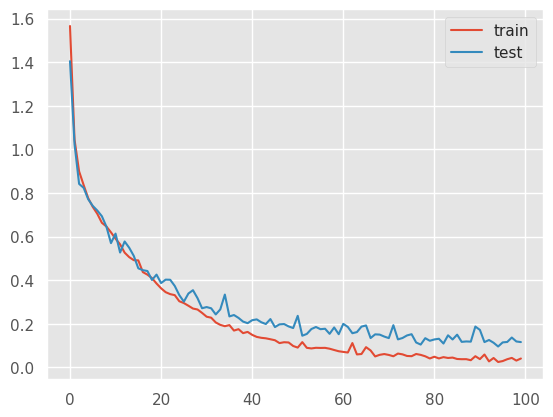

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
#pyplot.grid(False)

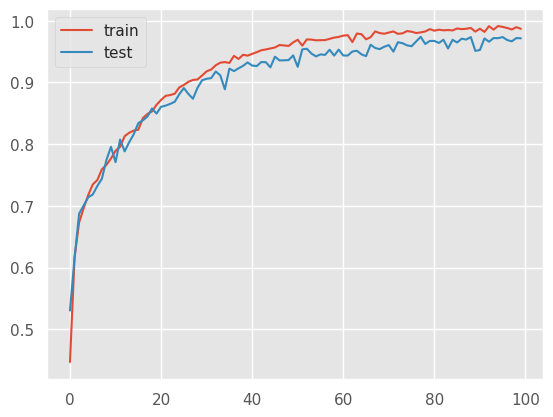

In [ ]:
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

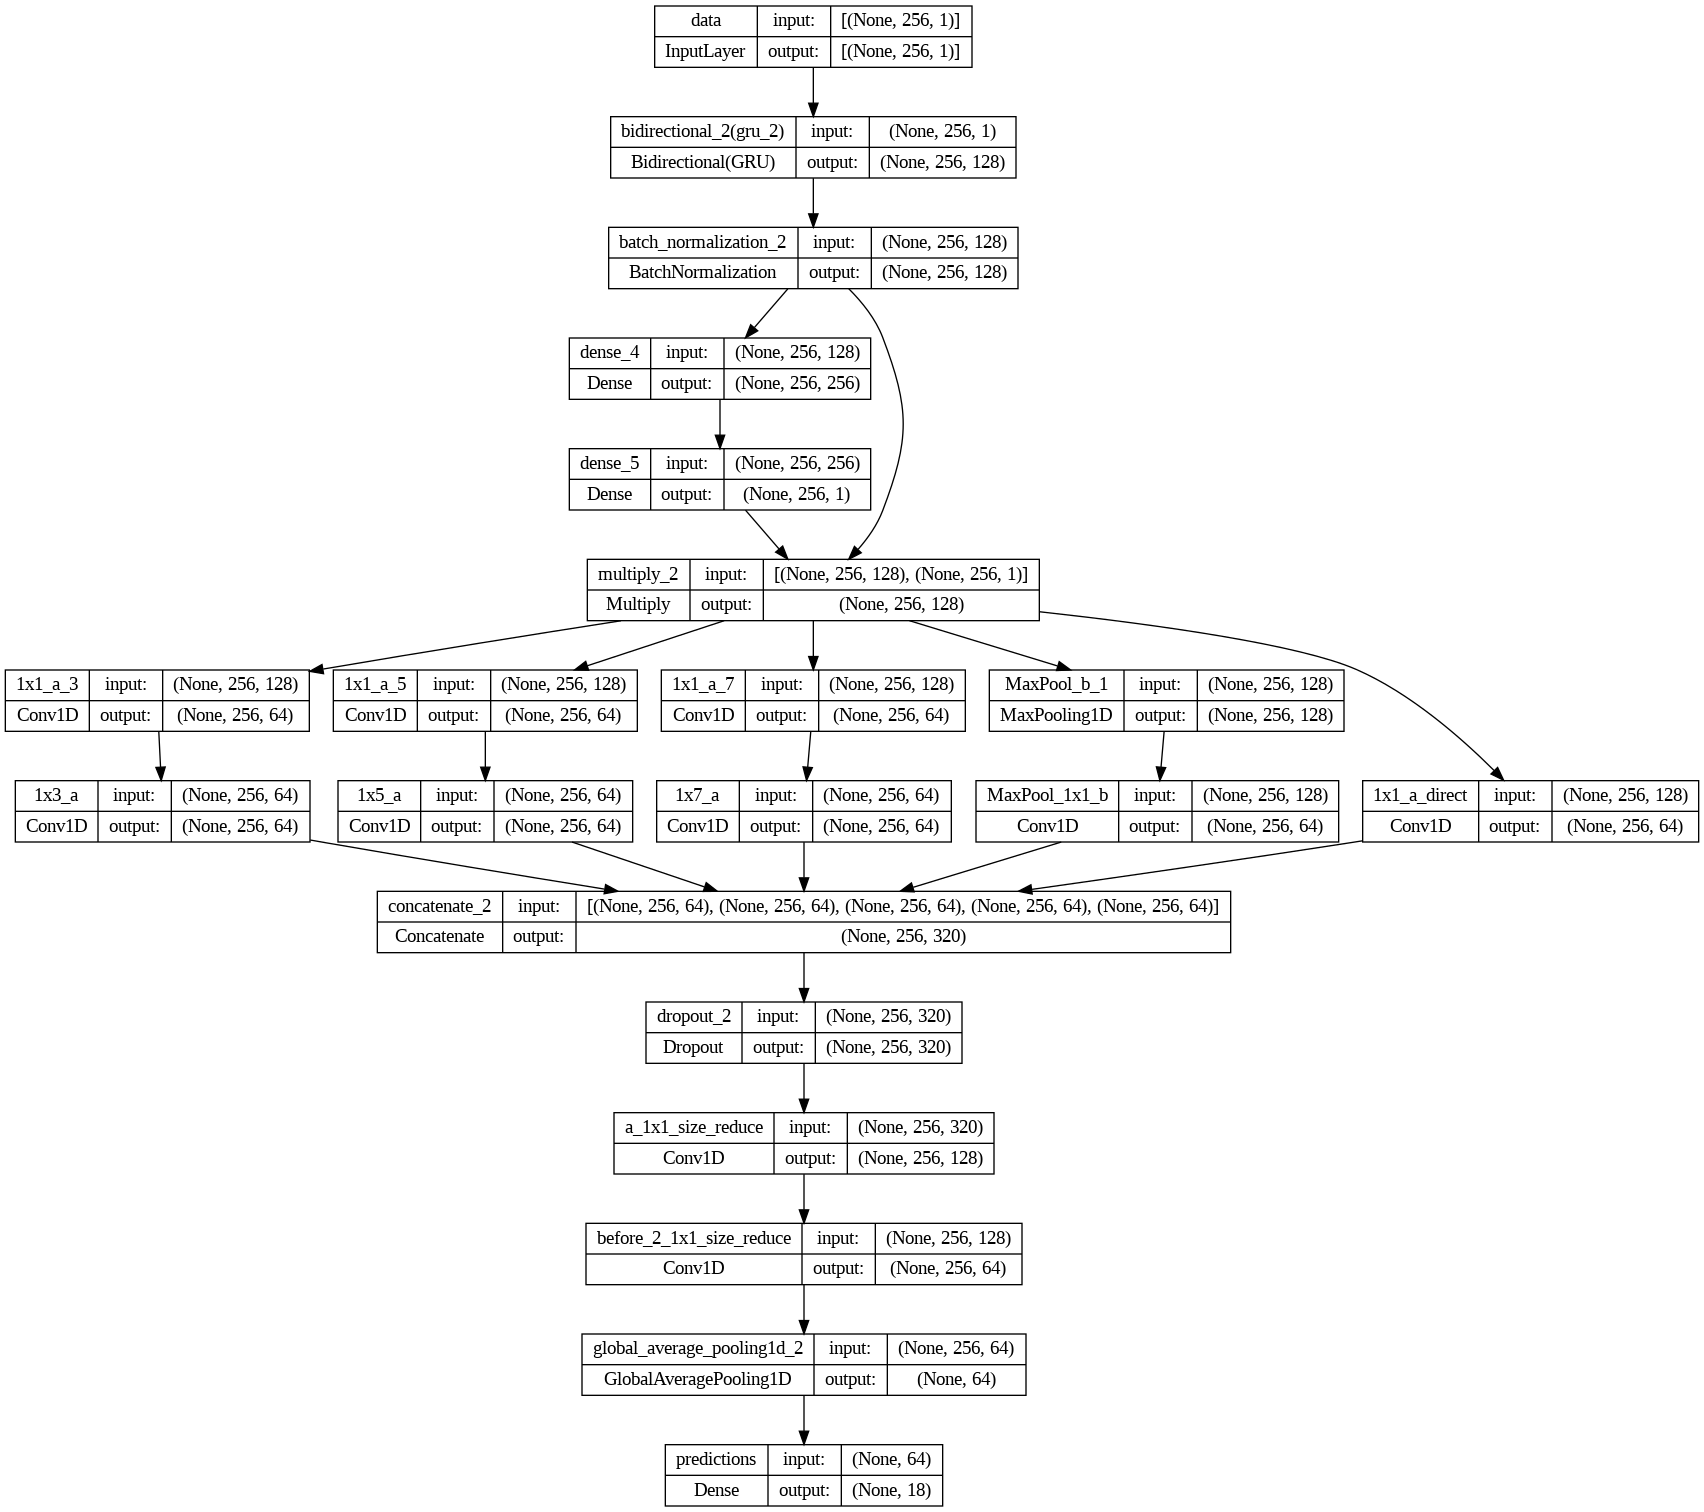

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
labels=['Walking',
'Jogging',
'Stairs',
'Sitting',
'Standing',
'Typing',
'Brushing Teeth',
'Eating Soup',
'Eating Chips',
'Eating Pasta',
'Drinking from Cup',
'Eating Sandwich',
'Kicking (Soccer Ball)',
'Playing Catch w/Tennis Ball',
'Dribblinlg (Basketball)',
'Writing',
'Clapping',
'Folding Clothes']

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# create a confusion matrix to visually represent incorrectly classified images
def plot_confusion_matrix(y_true, y_pred, classes, out_path=""):
    cm = confusion_matrix(y_true, y_pred,normalize="true")
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(18, 12))
    ax = sn.heatmap(df_cm, annot=True,square=False, cmap="YlGnBu", linewidths=.2, cbar_kws={"shrink": 0.8})
    return ax

154/154 [==============================] - 3s 11ms/step


<Axes: >

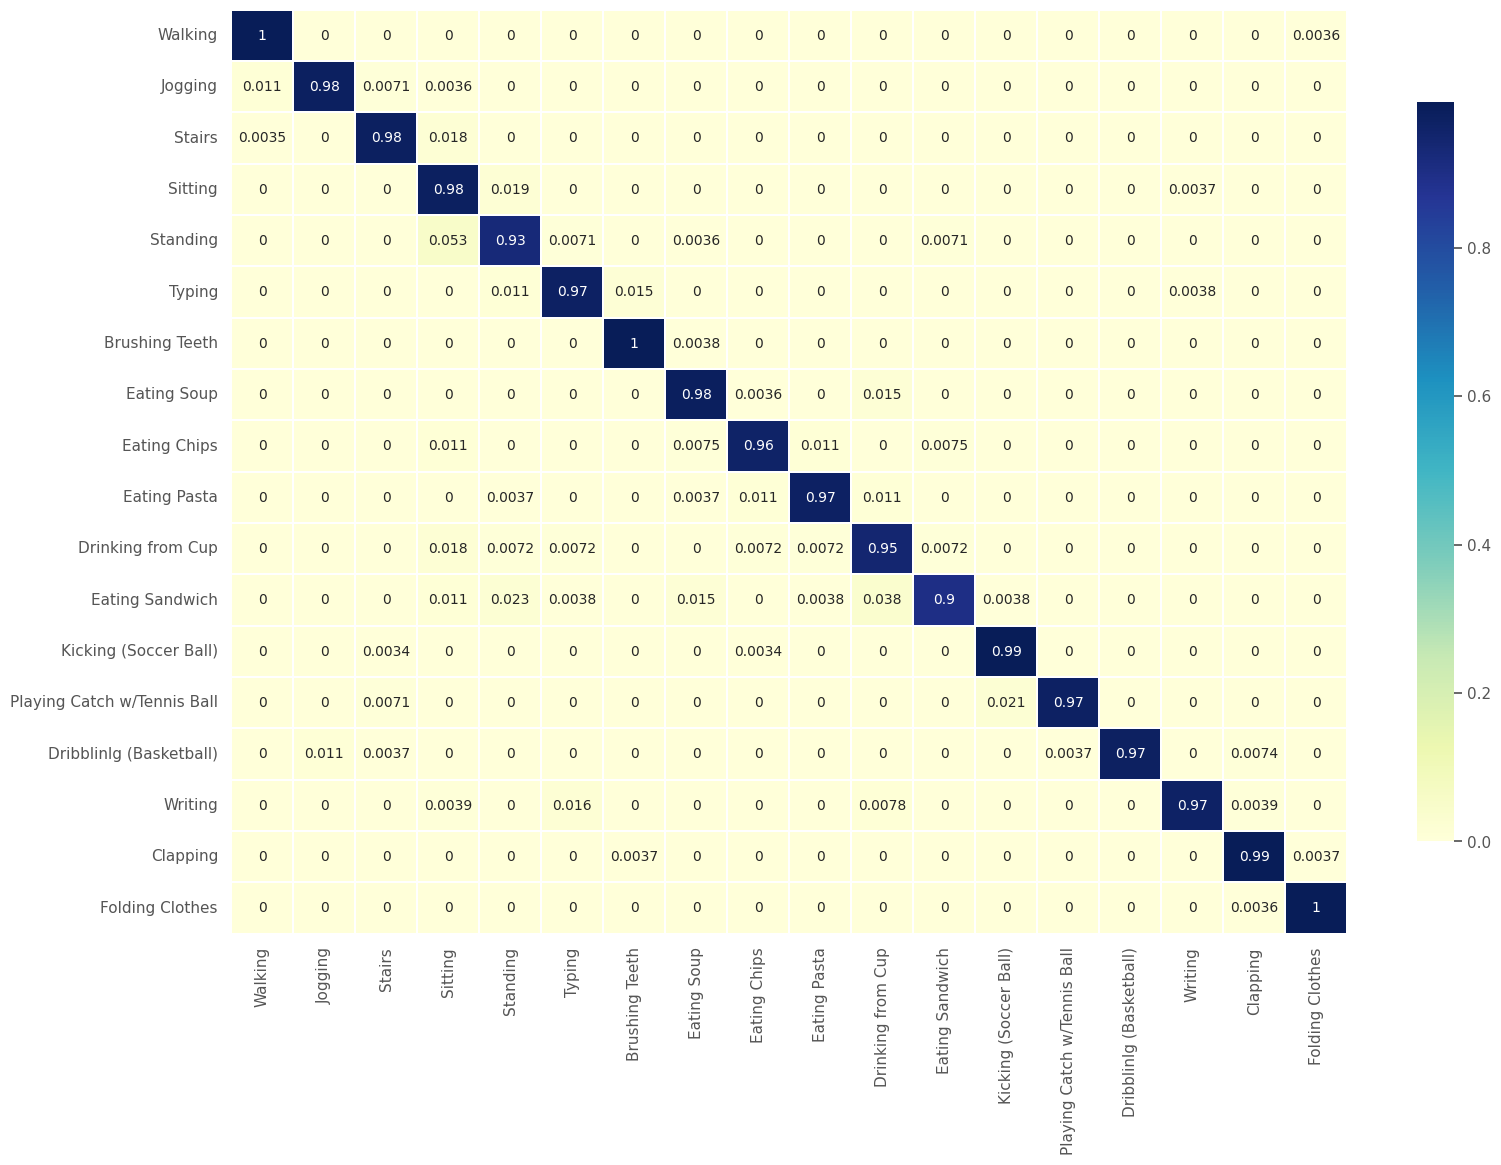

In [ ]:
y_pred=model.predict(X_test)
plot_confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1),labels)

154/154 [==============================] - 2s 14ms/step


<Axes: >

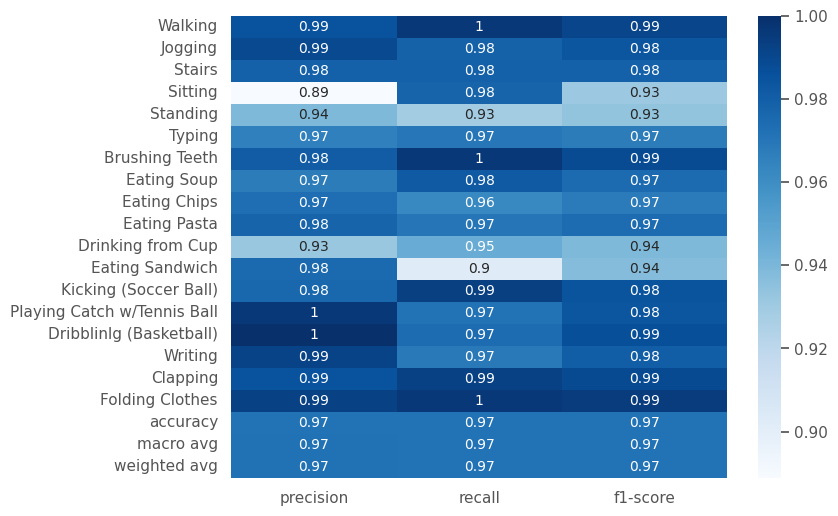

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns
y_pred=model.predict(X_test)
report= classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1),target_names=labels,output_dict=True)
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T,cmap="Blues", annot=True)